In [1]:
#Importing required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import pickle

In [23]:
#Reading data into df
df = pd.read_csv('diabetes_data.csv')

In [3]:
#Inital EDA
print(df.shape)
print(df.info()) #no missing values
print(df.columns)
print(df.head())

(768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   

In [4]:
#Basic Statistics 
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

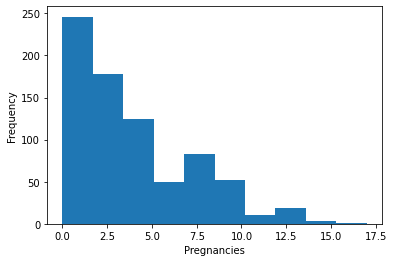

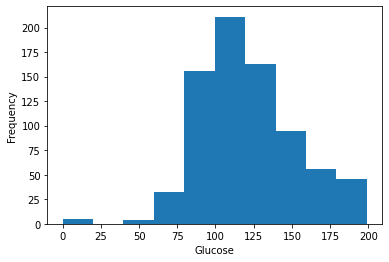

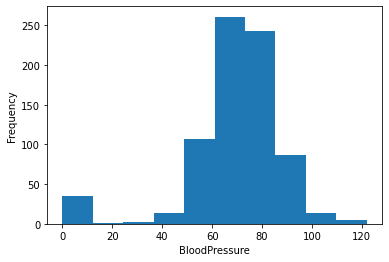

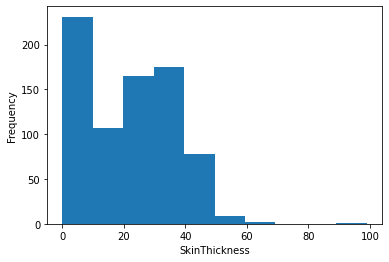

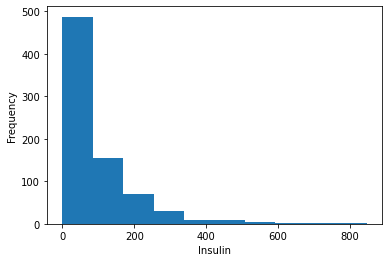

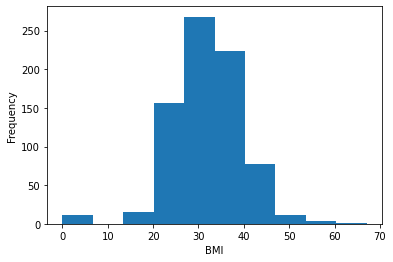

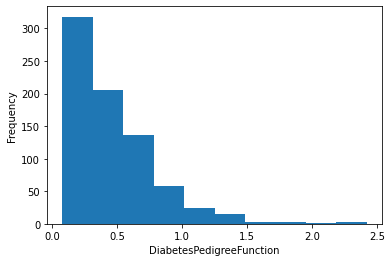

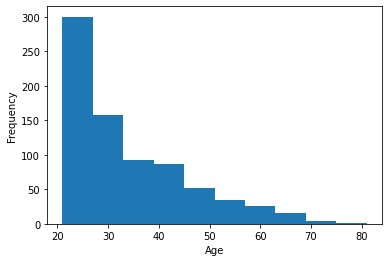

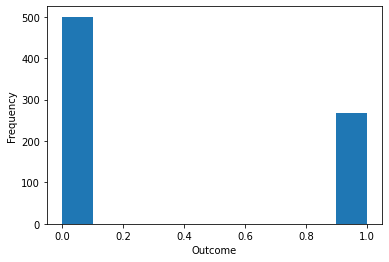

In [5]:
#General histogram for each column
for i in df.columns:
    plt.figure()
    df[i].plot.hist()
    plt.xlabel(i)
    plt.show()

In [24]:
#Determining number of Zero's in columns where it shouldn't exist
for i in ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']:
    print('{} column has {} zeros'.format(i,len(df[df[i]==0])))

Glucose column has 5 zeros
BloodPressure column has 35 zeros
SkinThickness column has 227 zeros
Insulin column has 374 zeros
BMI column has 11 zeros


In [25]:
#Removing rows where BloodPressure, Glucose, and BMI equal 0 (few rows)
df = df[(df['Glucose']!=0) & (df['BloodPressure']!=0) & df['BMI']!=0]
print(df)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                  

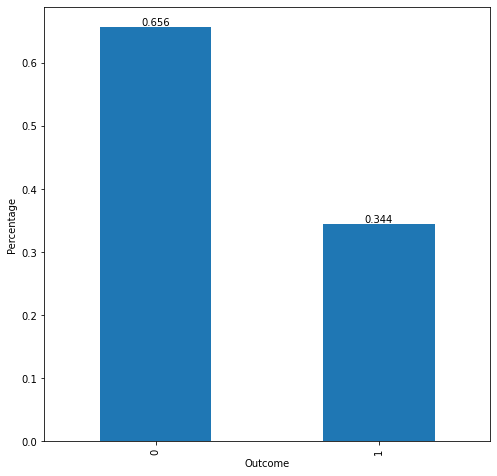

In [26]:
#Checking if data is imbalanced
freq = df['Outcome'].value_counts()/len(df)
plt.figure(figsize = (8,8))
freq.plot.bar()
for i in [0,1]:
    plt.text(i, np.round(freq[i],3), np.round(freq[i],3), ha='center', va='bottom')
plt.xlabel('Outcome')
plt.ylabel('Percentage')
plt.show()

In [9]:
#Splitting data into training and testing data
X = df.drop('Outcome',axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [10]:
#Replacing zero values with missing values for training data
for i in ['SkinThickness','Insulin']:
    X_train[i] = X_train[i].replace(0, np.nan)


C:\Users\rohan\AppData\Local\Temp/ipykernel_21936/3466514033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i] = X_train[i].replace(0, np.nan)


In [11]:
#Imputing SkinThickness and Insulin's medians for respective missing values in training data
median_imputer = SimpleImputer(strategy='median')
X_train = median_imputer.fit_transform(X_train)

<Figure size 432x288 with 0 Axes>

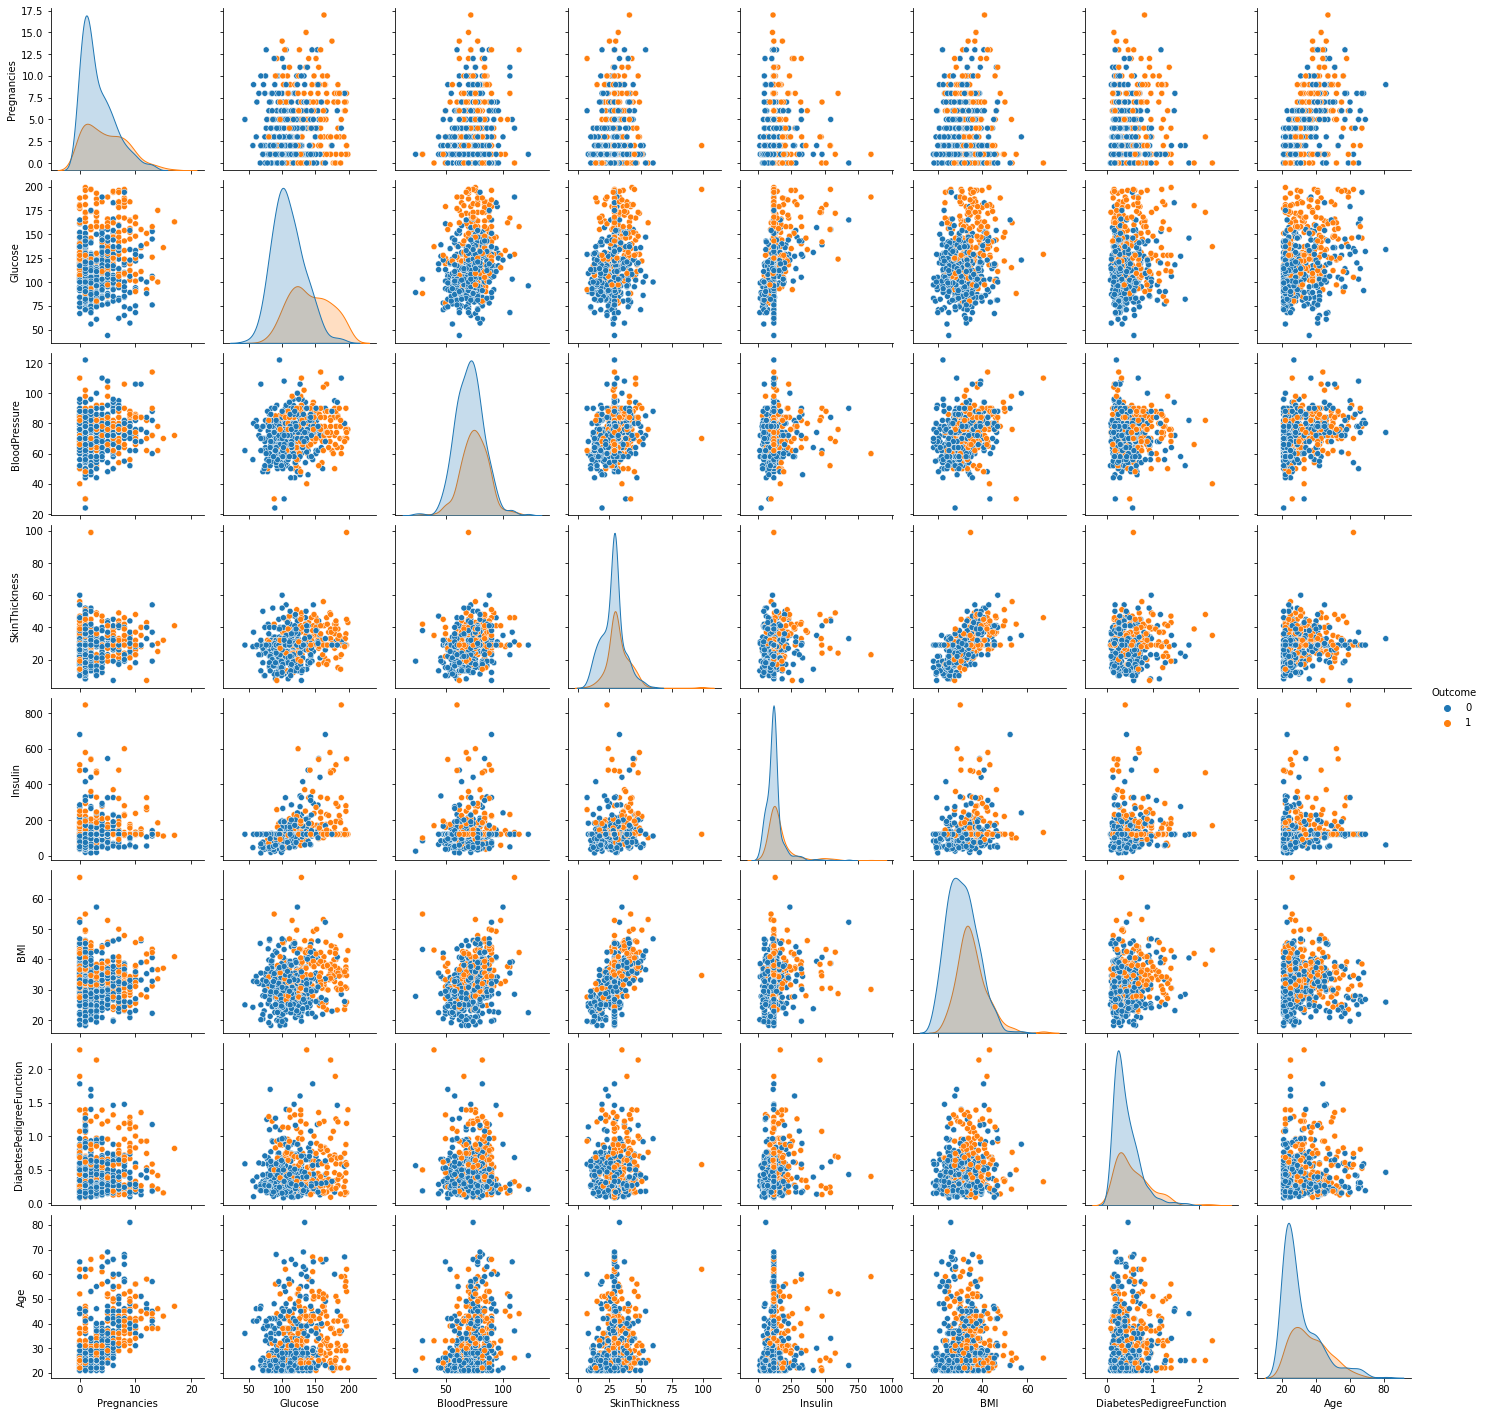

In [12]:
#Creating pairplot (see if labels are linearly separable) (doesn't seem like labels are linearly separable)
features = pd.DataFrame(X_train, columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
                                            'BMI', 'DiabetesPedigreeFunction', 'Age'])

target = pd.DataFrame(y_train, columns = ['Outcome']).reset_index().drop('index',axis=1)

train_data = pd.concat([features, target],axis=1)

plt.figure()
sns.pairplot(train_data, hue='Outcome')
plt.show()

# Random Forest

In [27]:
#Splitting data into train and test sets
X = df.drop('Outcome',axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [28]:
#Replacing zero values with missing values for training data (imputation step in pipeline)
for i in ['SkinThickness','Insulin']:
    X_train[i] = X_train[i].replace(0, np.nan)

C:\Users\rohan\AppData\Local\Temp/ipykernel_21936/2040136897.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i] = X_train[i].replace(0, np.nan)


In [29]:
#Replacing zero values with median for test data (imputation step in pipeline)
for i in ['SkinThickness','Insulin']:
    X_test[i] = X_test[i].replace(0, np.nan)

C:\Users\rohan\AppData\Local\Temp/ipykernel_21936/1816259253.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[i] = X_test[i].replace(0, np.nan)


In [16]:
#Creating Random Forest pipeline
rf_pipeline = Pipeline(steps=[['imputer', SimpleImputer(strategy='median')],
                              ['sampler', SMOTE(random_state=0, sampling_strategy=1.0)],
                              ['classifier', RandomForestClassifier(random_state=0)]])


In [17]:
#GridSearchCV
param_grid = {'classifier__n_estimators': np.arange(10,91,10),
              'classifier__max_features': ['auto','sqrt','log2'],
              'classifier__max_depth': [2,3,4,5]}
rf_grid = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, scoring='recall', cv=5, n_jobs=-1)
rf_grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[['imputer',
                                        SimpleImputer(strategy='median')],
                                       ['sampler',
                                        SMOTE(random_state=0,
                                              sampling_strategy=1.0)],
                                       ['classifier',
                                        RandomForestClassifier(random_state=0)]]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [2, 3, 4, 5],
                         'classifier__max_features': ['auto', 'sqrt', 'log2'],
                         'classifier__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
             scoring='recall')

Estimator with best parameters: {'classifier__max_depth': 2, 'classifier__max_features': 'auto', 'classifier__n_estimators': 90}

Mean recall for train set with best estimator: 0.7880512091038407


<Figure size 432x288 with 0 Axes>

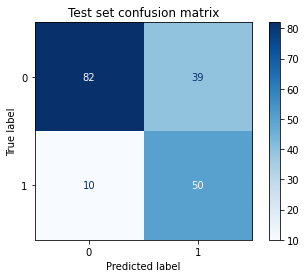


Test set classification report:
              precision    recall  f1-score   support

           0       0.89      0.68      0.77       121
           1       0.56      0.83      0.67        60

    accuracy                           0.73       181
   macro avg       0.73      0.76      0.72       181
weighted avg       0.78      0.73      0.74       181

Feature importances for best estimator:
                   Features  Importance
1                   Glucose    0.272573
7                       Age    0.226670
5                       BMI    0.163415
4                   Insulin    0.121574
3             SkinThickness    0.083959
6  DiabetesPedigreeFunction    0.068134
0               Pregnancies    0.052558
2             BloodPressure    0.011117


In [18]:
#Goodness of fit measures for best estimator after GridSearchCV
print('Estimator with best parameters: {}'.format(rf_grid.best_params_))
y_preds = rf_grid.best_estimator_.predict(X_test)
print('\nMean recall for train set with best estimator: {}'.format(rf_grid.best_score_))
labels = [0,1]
plt.figure()
plot_confusion_matrix(rf_grid.best_estimator_, X_test, y_test, display_labels = labels, cmap=plt.cm.Blues)
plt.title('Test set confusion matrix')
plt.show()
print('\nTest set classification report:\n{}'.format(classification_report(y_test, y_preds)))
print('Feature importances for best estimator:\n{}'.format(pd.DataFrame({'Features': X_train.columns, 'Importance': rf_grid.best_estimator_._final_estimator.feature_importances_}).sort_values('Importance',ascending=False)))

# SVM (non-linear)

In [30]:
#Creating SVM pipeline
svm_pipeline = Pipeline(steps=[['imputer', SimpleImputer(strategy='median')],
                               ['scaler', MinMaxScaler()],
                              ['sampler', SMOTE(random_state=0, sampling_strategy=1.0)],
                              ['clf', SVC(random_state=0)]])

In [31]:
#RandomizedSearchCV
param_grid = {'clf__kernel':['rbf','poly','sigmoid'],
              'clf__C':[1,10,100],
              'clf__degree': [2,3,4],
              'clf__gamma': [0.1,1,10]}
grid = RandomizedSearchCV(svm_pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1, random_state=0)
grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[['imputer',
                                              SimpleImputer(strategy='median')],
                                             ['scaler', MinMaxScaler()],
                                             ['sampler',
                                              SMOTE(random_state=0,
                                                    sampling_strategy=1.0)],
                                             ['clf', SVC(random_state=0)]]),
                   n_jobs=-1,
                   param_distributions={'clf__C': [1, 10, 100],
                                        'clf__degree': [2, 3, 4],
                                        'clf__gamma': [0.1, 1, 10],
                                        'clf__kernel': ['rbf', 'poly',
                                                        'sigmoid']},
                   random_state=0, scoring='recall')

Estimator with best parameters: {'clf__kernel': 'rbf', 'clf__gamma': 1, 'clf__degree': 2, 'clf__C': 10}

Mean recall for train set with best estimator: 0.7716927453769559


<Figure size 432x288 with 0 Axes>

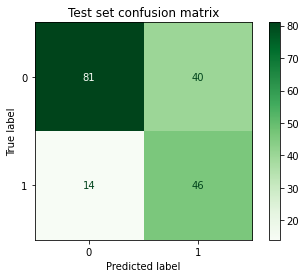


Test set classification report:
              precision    recall  f1-score   support

           0       0.85      0.67      0.75       121
           1       0.53      0.77      0.63        60

    accuracy                           0.70       181
   macro avg       0.69      0.72      0.69       181
weighted avg       0.75      0.70      0.71       181



In [32]:
#GOF measures for best estimator (based on RandomizedSearchCV)
print('Estimator with best parameters: {}'.format(grid.best_params_))
print('\nMean recall for train set with best estimator: {}'.format(grid.best_score_))
labels = [0,1]
plt.figure()
plot_confusion_matrix(grid.best_estimator_, X_test, y_test, display_labels = labels, cmap=plt.cm.Greens)
plt.title('Test set confusion matrix')
plt.show()
y_pred = grid.best_estimator_.predict(X_test)
print('\nTest set classification report:\n{}'.format(classification_report(y_test, y_pred)))

# Pickling the Better Model

In [22]:
#Random forest performed better based on recall and f1-score (train and test accuracy were only slightly less)
file = open('rf_model.pkl', 'wb')
pickle.dump(rf_grid.best_estimator_, file)
file.close()